# Exercise 8.8

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import time
random.seed(0)
np.random.seed(0)

In [2]:
class MDP:
	def __init__(self, number_of_states, branching_factor, termination_probability):
		self.number_of_states = number_of_states
		self.branching_factor = branching_factor
		self.termination_probability = termination_probability
		self.transitions = {}
		self.state_means = np.random.normal(loc=0.0, scale=1.0, size=number_of_states)

		for a in range(2):
			for s in range(number_of_states):
				self.transitions[(s, a)] = (s + np.asarray(random.sample(range(1, number_of_states), branching_factor))) % number_of_states

	def transition(self, s, a):
		# Returns: next_state, reward, terminal
		next_state = random.choice(self.transitions[(s, a)])
		#reward = np.random.normal(loc=self.state_means[next_state], scale=1.0)
		reward = self.state_means[next_state]
		terminal = False
		if random.random() < self.termination_probability:
			terminal = True
		return next_state, reward, terminal
	
	def possible_next_states(self, s, a):
		return self.transitions[(s, a)]

In [3]:
class OnPolicyAgent:
    def __init__(self, mdp, epsilon, alpha, gamma):
        self.mdp = mdp
        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma
        self.q_values = np.zeros((mdp.number_of_states, 2))
    
    def reset(self):
        self.q_values = np.zeros((self.mdp.number_of_states, 2))

    def get_action(self, state, rand = True):
        if random.random() < self.epsilon and rand:
            return random.choice([0, 1])
        else:
            return np.argmax(self.q_values[state])
    
    def update(self, state, action, reward, next_state, terminal):
        if terminal:
            td_target = reward
        else:
            td_target = reward + self.gamma * np.max(self.q_values[next_state])
        td_error = td_target - self.q_values[state, action]
        self.q_values[state, action] += self.alpha * td_error

class UniformAgent:
    def __init__(self, mdp, gamma):
        self.mdp = mdp
        self.gamma = gamma
        self.q_values = np.zeros((mdp.number_of_states, 2))
    
    def reset(self):
        self.q_values = np.zeros((self.mdp.number_of_states, 2))

    def do_update_step(self):
        state = random.randint(0, self.mdp.number_of_states - 1)
        action = random.choice([0, 1])
        possible_next_states = self.mdp.possible_next_states(state, action)
        Q = 0
        for next_state in possible_next_states:
            Q += 1.0 / len(possible_next_states) * self.mdp.state_means[next_state]
            Q += 1.0 / len(possible_next_states) * (1 - self.mdp.termination_probability) * self.gamma * self.q_values[next_state, np.argmax(self.q_values[next_state])]
        self.q_values[state, action] = Q

In [4]:
def run_experiment(mdp, max_time, num_experiments):
    on_policy_agent = OnPolicyAgent(mdp, 0.1, 0.1, 0.9)
    uniform_agent = UniformAgent(mdp, 0.9)
    q_first_state_opa = []
    q_first_state_ua = []

    for i in range(num_experiments):
        on_policy_agent.reset()
        uniform_agent.reset()
        terminal = False
        state = 0

        q_first_state_opa_experiment = []
        experiment_start_time = time.time()
        while time.time() - experiment_start_time < max_time:
            # On-policy agent step
            action = on_policy_agent.get_action(state)
            next_state, reward, terminal = mdp.transition(state, action)
            on_policy_agent.update(state, action, reward, next_state, terminal)
            state = 0 if terminal else next_state
            # Record Q-values for the first state
            q_first_state_opa_experiment.append(
                on_policy_agent.q_values[0, np.argmax(on_policy_agent.q_values[0])]
            )

        q_first_state_ua_experiment = []
        experiment_start_time = time.time()
        while time.time() - experiment_start_time < max_time:
            # Uniform agent step
            uniform_agent.do_update_step()

            # Record Q-values for the first state
            q_first_state_ua_experiment.append(
                uniform_agent.q_values[0, np.argmax(uniform_agent.q_values[0])]
            )

        # Store results for this experiment
        q_first_state_opa.append(q_first_state_opa_experiment)
        q_first_state_ua.append(q_first_state_ua_experiment)
    return q_first_state_opa, q_first_state_ua


In [5]:
max_time = 1  # Maximal time in seconds for each experiment
num_experiments = 1000

q_first_state_opa_3, q_first_state_ua_3 = run_experiment(MDP(10000, 3, 0.1), max_time, num_experiments)
q_first_state_opa_1, q_first_state_ua_1 = run_experiment(MDP(10000, 1, 0.1), max_time, num_experiments)


In [ ]:
# Normalize lengths for plotting
max_length = max(max(len(q) for q in q_first_state_opa_3),
                 max(len(q) for q in q_first_state_ua_3),
                 max(len(q) for q in q_first_state_opa_1),
                 max(len(q) for q in q_first_state_ua_1))
time_axis = np.linspace(0, max_time, max_length)

def resample_and_average(data, max_length):
    # Not enough memory to store all data then average
    sum_resampled_data = np.zeros((max_length))
    for i, q_values in enumerate(data):
        x_original = np.linspace(0, 1, len(q_values))
        x_resampled = np.linspace(0, 1, max_length)
        sum_resampled_data += np.interp(x_resampled, x_original, q_values)
    return sum_resampled_data / len(data)

# Resample and average data
q_first_state_opa_resampled_3 = resample_and_average(q_first_state_opa_3, max_length)
q_first_state_ua_resampled_3 = resample_and_average(q_first_state_ua_3, max_length)
q_first_state_opa_resampled_1 = resample_and_average(q_first_state_opa_1, max_length)
q_first_state_ua_resampled_1 = resample_and_average(q_first_state_ua_1, max_length)

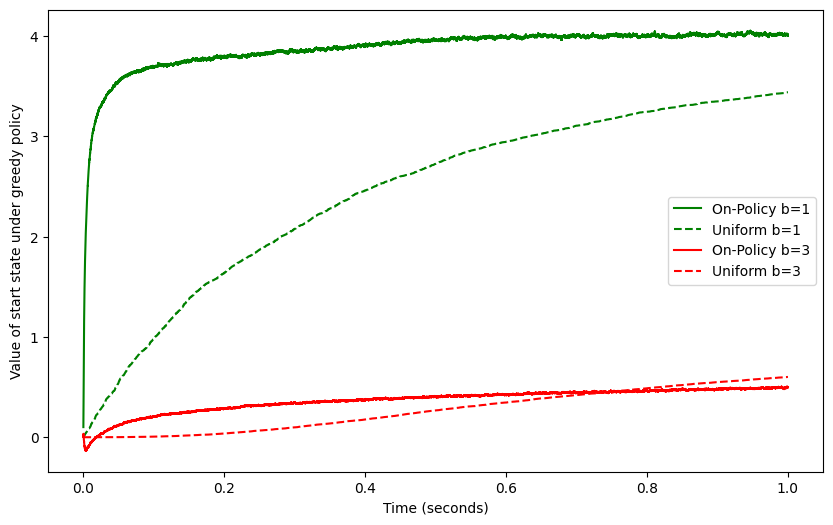

In [15]:
# Plot results

plt.figure(figsize=(10, 6))
plt.plot(time_axis, q_first_state_opa_resampled_1, label='On-Policy b=1', color='green')
plt.plot(time_axis, q_first_state_ua_resampled_1, label='Uniform b=1', color='green', linestyle='dashed')
plt.plot(time_axis, q_first_state_opa_resampled_3, label='On-Policy b=3', color='red')
plt.plot(time_axis, q_first_state_ua_resampled_3, label='Uniform b=3', color='red', linestyle='dashed')
plt.xlabel('Time (seconds)')
plt.ylabel('Value of start state under greedy policy')
plt.legend()
plt.savefig("../chapters_latex/figures/ex_08_08.pdf")
plt.show()